In [2]:
# Figures prepared by [Anmol Lakhotia](https://www.linkedin.com/in/anmol-m-lakhotia)

# Importing Packages 
import numpy as np
import pandas as pd
from scipy.optimize import root
import matplotlib.pyplot as plt

In [3]:
# Inverse function for transforming utility back to regret
def f_inv(u, gamma, pbar, plow):
    if gamma == 1.0:
        return np.exp(np.log(pbar) + u*(np.log(pbar) - np.log(plow)))
    return ((u * ((pbar**(1-gamma)) - (plow**(1-gamma))) + (plow**(1-gamma))) ** (1/(1-gamma)))

# Utility function for regret calculation based on gamma (inequality aversion)
def f(x, gamma, pbar, plow):
    if gamma == 1.0:
        return (np.log(x) - np.log(pbar))/(np.log(pbar) - np.log(plow))
    return ((x ** (1 - gamma) / (1 - gamma)) - (plow ** (1 - gamma) / (1 - gamma))) / ((pbar ** (1 - gamma) / (1 - gamma)) - (plow ** (1 - gamma) / (1 - gamma)))

# LHS function: Regret for treatment b when fraction delta is assigned to treatment a
def LHS(upper_bound_b, lower_bound_a, gamma, delta, pbar, plow):
    return upper_bound_b - f_inv(f(lower_bound_a, gamma, pbar, plow) + delta * (f(upper_bound_b, gamma, pbar, plow) - f(lower_bound_a, gamma, pbar, plow)), gamma, pbar, plow)

# RHS function: Regret for treatment a when fraction delta is assigned to treatment a
def RHS(lower_bound_b, upper_bound_a, gamma, delta, pbar, plow):
    return upper_bound_a - f_inv(f(upper_bound_a, gamma, pbar, plow) + delta * (f(lower_bound_b, gamma, pbar, plow) - f(upper_bound_a, gamma, pbar, plow)), gamma, pbar, plow)

# Function to find the optimal delta where LHS = RHS (minimizing regret)
def solve_for_optimal_delta(upper_bound_b, lower_bound_a, lower_bound_b, upper_bound_a, gamma, pbar, plow):
    def system(delta):
        return LHS(upper_bound_b, lower_bound_a, gamma, delta, pbar, plow) - RHS(lower_bound_b, upper_bound_a, gamma, delta, pbar, plow)
    
    # Use scipy's root function to find the zero of the system
    solution = root(system, 0.5)  # Initial guess of 0.5 for delta
    return solution.x[0]

In [4]:
# Plotting function for Left figure 2
def render_bounds_plot(lower_bound_a, upper_bound_a, lower_bound_b, upper_bound_b, gamma, title, pbar, plow):
    # Transform the bounds using the inverse function
    upper_a = f_inv(upper_bound_a, gamma, pbar, plow)
    lower_a = f_inv(lower_bound_a, gamma, pbar, plow)
    upper_b = f_inv(upper_bound_b, gamma, pbar, plow)
    lower_b = f_inv(lower_bound_b, gamma, pbar, plow)
    
    # Calculate LHS and RHS over delta from 0 to 1
    delta_values = np.linspace(0, 1, 100)
    lhs_values = [LHS(upper_b, lower_a, gamma, delta, pbar, plow) for delta in delta_values]
    rhs_values = [RHS(lower_b, upper_a, gamma, delta, pbar, plow) for delta in delta_values]
    
    # Find the higher of the LHS and RHS for each delta
    higher_values = np.maximum(lhs_values, rhs_values)

    # Find the optimal delta where LHS and RHS intersect
    optimal_delta = solve_for_optimal_delta(upper_b, lower_a, lower_b, upper_a, gamma, pbar, plow)
    optimal_value = LHS(upper_b, lower_a, gamma, optimal_delta, pbar, plow)
    
    # Calculate RHS value at delta = 1 for the new dashed line
    rhs_at_one = RHS(lower_b, upper_a, gamma, 1, pbar, plow)
    
    # LHS and RHS values at delta = 0
    lhs_at_zero = LHS(upper_b, lower_a, gamma, 0, pbar, plow)
    rhs_at_zero = RHS(lower_b, upper_a, gamma, 0, pbar, plow)

    # Plot the bright red thin dotted line for the higher values
    plt.plot(delta_values, higher_values+.011, linestyle='--', color='silver', linewidth=3.5)

    # Check for intersection within [0, 1] and positive value
    if not np.isnan(optimal_delta) and 0 <= optimal_delta <= 1 and optimal_value > 0:
        # Plot LHS and RHS curves with intersection point and labels
        plt.plot(delta_values, lhs_values, label='LHS (Treatment b)', linestyle=(0, (1, 1)), color='#1F77B4', linewidth=3)
        plt.plot(delta_values, rhs_values, label='RHS (Treatment a)', linestyle=(0, (1, 1)), color='#FFCC00', linewidth=3)
        
        # Draw dashed line from x-axis up to the optimal intersection point
        plt.plot([optimal_delta, optimal_delta], [0, optimal_value], linestyle='dashed', color='black', linewidth=0.75)
        plt.scatter(optimal_delta, optimal_value, color='black', s=50)
        
        # Add dashed line at x = 1 up to the value of RHS(1)
        plt.plot([1, 1], [0, rhs_at_one], linestyle='dashed', color='black', linewidth=0.75)
        
        # Horizontal dashed lines to the left of the optimal delta
        plt.plot([0, 1], [rhs_at_one, rhs_at_one], linestyle='dashed', color='black', linewidth=0.75)
        
        # Add thick black lines for x = 0 and y = 0
        plt.axvline(x=0, linestyle='solid', color='black', linewidth=1.5)
        plt.axhline(y=0, linestyle='solid', color='black', linewidth=1.5)
    else:
        # Compare LHS at delta = 0 and RHS at delta = 1
        lhs_0 = LHS(upper_b, lower_a, gamma, 0, pbar, plow)
        rhs_1 = RHS(lower_b, upper_a, gamma, 1, pbar, plow)
        
        # Select the minimum regret point
        if lhs_0 < rhs_1:
            min_delta = 0
            min_value = lhs_0
        else:
            min_delta = 1
            min_value = rhs_1
        
        # Plot LHS and RHS curves with minimum point and labels
        plt.plot(delta_values, lhs_values, label='LHS (Treatment b)', linestyle=(0, (1, 1)), color='#1F77B4', linewidth=3)
        plt.plot(delta_values, rhs_values, label='RHS (Treatment a)', linestyle=(0, (1, 1)), color='#FFCC00', linewidth=3)
        plt.scatter(min_delta, min_value, color='darkred', s=50)
        
        # Add dashed line at x = 1 up to the value of RHS(1)
        plt.plot([1, 1], [0, rhs_1], linestyle='dashed', color='black', linewidth=0.75)
        
        # Horizontal dashed lines to the left of the minimum delta
        plt.plot([0, min_delta], [min_value, min_value], linestyle='dashed', color='black', linewidth=0.75)
        plt.plot([0, 1], [rhs_1, rhs_1], linestyle='dashed', color='black', linewidth=0.75)
        
        # Add thick black lines for x = 0 and y = 0
        plt.axvline(x=0, linestyle='solid', color='black', linewidth=1.5)
        plt.axhline(y=0, linestyle='solid', color='black', linewidth=1.5)

    # Add y-axis ticks with labels at LHS(0) and RHS(0)
    plt.yticks([lhs_at_zero, rhs_at_one, 1], [r'$\overline{p} - p(a)$', r'$p(a) - \mathdefault{p̲}$', 'Regret'])
    
    # Add x-axis tick for optimal delta with label
    plt.xticks([0, optimal_delta, 1, 1.15], [r'$0$', rf'$\delta^{{\star}} = 1 - p(a)$', r'$1$', r'$\delta$'])
    
    # Additional plot settings
#    plt.title(title)
#    plt.legend()
    plt.xlim(0, 1.15)
    plt.ylim(0, 1)
    plt.grid(False)

    # Remove the outer box (top and right spines)
    ax = plt.gca()  # Get current axes
    ax.spines['top'].set_visible(False)  # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    
    plt.savefig('Figure_2a.png', format='png')
    
    plt.show()

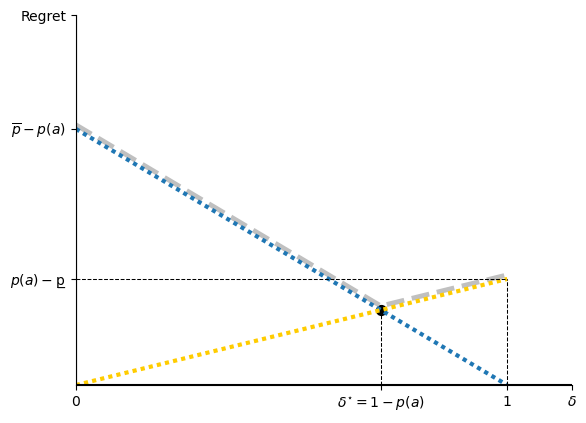

In [5]:
#render_bounds_plot(lower_bound_a, upper_bound_a, lower_bound_b, upper_bound_b, gamma, title)
# Example usage
pa = .3
plow = .01
pbar = 1
render_bounds_plot(pa, pa, plow, pbar, 0, "Gamma = 0", pbar, plow)

In [6]:
# Plotting finction for Right figure 2

def render_bounds_plot_with_two_gammas(lower_bound_a, upper_bound_a, lower_bound_b, upper_bound_b, gamma1, gamma2, title, pbar, plow):
    # Define a function to calculate LHS, RHS, and higher values for a given gamma
    def calculate_values(gamma):
        upper_a = f_inv(upper_bound_a, gamma, pbar, plow)
        lower_a = f_inv(lower_bound_a, gamma, pbar, plow)
        upper_b = f_inv(upper_bound_b, gamma, pbar, plow)
        lower_b = f_inv(lower_bound_b, gamma, pbar, plow)
        
        delta_values = np.linspace(0, 1, 100)
        lhs_values = [LHS(upper_b, lower_a, gamma, delta, pbar, plow) for delta in delta_values]
        rhs_values = [RHS(lower_b, upper_a, gamma, delta, pbar, plow) for delta in delta_values]
        higher_values = np.maximum(lhs_values, rhs_values)
        
        optimal_delta = solve_for_optimal_delta(upper_b, lower_a, lower_b, upper_a, gamma, pbar, plow)
        optimal_value = LHS(upper_b, lower_a, gamma, optimal_delta, pbar, plow)
        
        rhs_at_one = RHS(lower_b, upper_a, gamma, 1, pbar, plow)
        lhs_at_zero = LHS(upper_b, lower_a, gamma, 0, pbar, plow)
        rhs_at_zero = RHS(lower_b, upper_a, gamma, 0, pbar, plow)
        
        return delta_values, lhs_values, rhs_values, higher_values, optimal_delta, optimal_value, rhs_at_one, lhs_at_zero, rhs_at_zero

    # Calculate values for the first gamma
    delta_values1, lhs_values1, rhs_values1, higher_values1, optimal_delta1, optimal_value1, rhs_at_one1, lhs_at_zero1, rhs_at_zero1 = calculate_values(gamma1)
    # Calculate values for the second gamma
    delta_values2, lhs_values2, rhs_values2, higher_values2, optimal_delta2, optimal_value2, rhs_at_one2, lhs_at_zero2, rhs_at_zero2 = calculate_values(gamma2)

#    plt.plot(delta_values1, higher_values1+.0125, linestyle='-', color='#BAB86C', linewidth=.5, zorder=1)  # Black outline
#    plt.plot(delta_values2, higher_values2+.0155, linestyle='-', color='#BAB86C', linewidth=4.5, zorder=1)  # Black outline
#    plt.plot(delta_values1, higher_values1+.0125, linestyle='--', color='#8FA25A', linewidth=3.5, label=f'Higher Value γ={gamma1}')
#    plt.plot(delta_values2, higher_values2+.0155, linestyle='-', color='#8FA25A', linewidth=3.5, label=f'Higher Value γ={gamma2}')

    plt.plot(delta_values1, higher_values1+.0125, linestyle='-', color='lightgrey', linewidth=.5, zorder=1)  # Black outline
    plt.plot(delta_values2, higher_values2+.0155, linestyle='-', color='lightgrey', linewidth=4.5, zorder=1)  # Black outline
    plt.plot(delta_values1, higher_values1+.0125, linestyle='--', color='silver', linewidth=3.5, label=f'Higher Value γ={gamma1}')
    plt.plot(delta_values2, higher_values2+.0155, linestyle='-', color='silver', linewidth=3.5, label=f'Higher Value γ={gamma2}')

    # Plot curves for the first gamma value (using dashed lines)
    plt.plot(delta_values1, lhs_values1, label=f'LHS (Treatment b) γ={gamma1}', color='#1F77B4', linestyle=(0, (1, 1)), linewidth=3.5)
    plt.plot(delta_values1, rhs_values1, label=f'RHS (Treatment a) γ={gamma1}', color='#FFCC00', linestyle=(0, (1, 1)), linewidth=3.5)

    # Plot optimal delta and associated lines for the first gamma value
    plt.plot([optimal_delta1, optimal_delta1], [0, optimal_value1], linestyle='dashed', color='black', linewidth=0.75)
    plt.scatter(optimal_delta1, optimal_value1, color='black', s=50)
    plt.plot([1, 1], [0, rhs_at_one1], linestyle='dashed', color='black', linewidth=0.75)
    plt.axvline(x=0, linestyle='solid', color='black', linewidth=1.5)
    plt.axhline(y=0, linestyle='solid', color='black', linewidth=1.5)
    
    # Plot curves for the second gamma value (using solid lines)
    plt.plot(delta_values2, lhs_values2, label=f'LHS (Treatment b) γ={gamma2}', color='#1F77B4', linewidth=3.5)
    plt.plot(delta_values2, rhs_values2, label=f'RHS (Treatment a) γ={gamma2}', color='#FFCC00', linewidth=3.5)

    # Plot optimal delta and associated lines for the second gamma value
    plt.plot([optimal_delta2, optimal_delta2], [0, optimal_value2], linestyle='dashed', color='black', linewidth=0.75)
    plt.scatter(optimal_delta2, optimal_value2, color='black', s=50)
    plt.plot([1, 1], [0, rhs_at_one2], linestyle='dashed', color='black', linewidth=0.75)
    
    # Add ticks and labels for both gammas on the y-axis and x-axis
    plt.yticks([lhs_at_zero1, optimal_value1, lhs_at_zero2, rhs_at_one2], 
               [r'$\overline{p} - p(a)$', r'$p(a) - \mathdefault{p̲}$', r'$\overline{p} - ee(a)$', r'$ee(a) - \mathdefault{p̲}$'])
    
    plt.text(-.125, .975, "Regret", fontsize=10, verticalalignment='center')

    plt.xticks([0, optimal_delta1, optimal_delta2, 1], 
               [r'$0$', rf'$\delta^{{\star}}_{"N"}$', rf'$\delta^{{\star}}_{"A"}$', r'$1$'])
    
    plt.text(1.1, -.045, rf'$\delta$' , fontsize=10, verticalalignment='center')

    # Additional plot settings
    #plt.title(title)
    #plt.xlabel('Delta (Fraction Assigned to Treatment B)')
    #plt.ylabel(f'Egalitarian Equivalent Regret (Gamma = {gamma1}, {gamma2})')
    plt.xlim(0, 1.10)
    plt.ylim(0, 1)
    plt.grid(False)

    # Remove the outer box (top and right spines)
    ax = plt.gca()  # Get current axes
    ax.spines['top'].set_visible(False)  # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    
    plt.savefig('Figure_2b.png', format='png')
    
    plt.show()


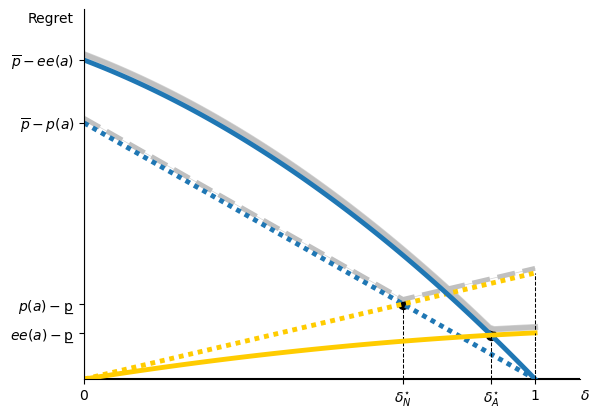

In [7]:
#render_bounds_plot_with_two_gammas(lower_bound_a, upper_bound_a, lower_bound_b, upper_bound_b, gamma1, gamma2, title, pbar, plow)
# Example usage
render_bounds_plot_with_two_gammas(pa, pa, plow, pbar, 0, .5, "Comparison of Gammas 0 and .5", pbar, plow)